# Linear Predictive Analysis
---
## Shreya Laddha - 180070054
---

### Given the speech segment (aa.wav) extracted from the word “pani” in “machali.wav” (male voice), sampled at 8 kHz, do the following

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from scipy import signal as sg
from scipy.io.wavfile import write
import scipy.io.wavfile as wav
from matplotlib import patches
from collections import defaultdict
from IPython.display import Audio


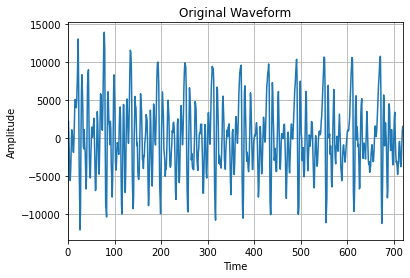

In [2]:
Fs, signal = wav.read('aa.wav')

plt.figure()
plt.plot(signal)
plt.title("Original Waveform")
plt.grid()
plt.xlim(xmin=0)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig("plots/OriginalSignal.png")

1. Apply pre-emphasis to the signal. 


Pre-emphasis is applied using a High Pass Filter which is of the form, H(z) = 1 - $\alpha z^{-1}$. Here I have chosen the parameter $\alpha$ (used to make the spectrum of signal a bit uniform) as 0.98.

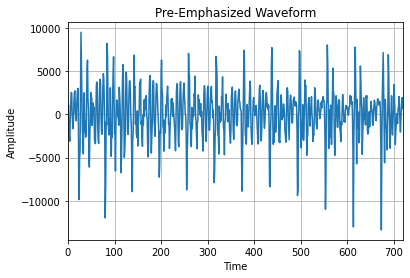

In [3]:
def pre_emphasis(x):
    alpha = 0.98;
    y = np.zeros(len(x));
    for i in range(1, len(x)):
        y[i] = x[i] - alpha*x[i-1];
    return y

preEmpSignal = pre_emphasis(signal);

fig = plt.figure()
plt.plot(preEmpSignal)
plt.title("Pre-Emphasized Waveform")
plt.grid()
plt.xlim(xmin=0)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig("plots/PreEmphasized.png")


2. Compute and plot the narrowband magnitude spectrum slice using a Hamming window 
of duration = 30 ms on a segment near the centre of the given audio file. 


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


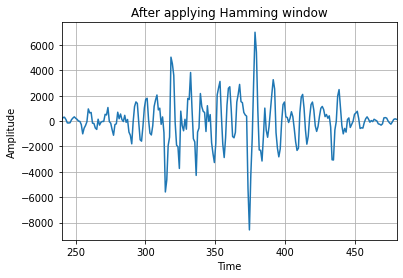

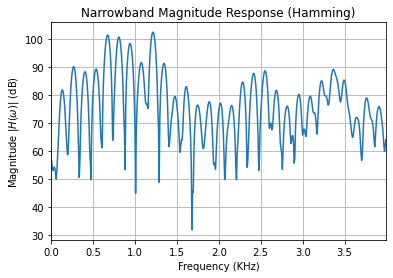

In [4]:
def narrowband_spectrum(signal,duration, Fs):
    center = int(len(signal)/2)
    window_length = int((duration/1000)*Fs) #duration in ms
    half_win_len = int(window_length/2)
    windowed_signal = signal[center-half_win_len:center+half_win_len]
    narrowband_output = np.hamming(window_length)*windowed_signal
    return narrowband_output, center, window_length

narrowband_output, center, window_length = narrowband_spectrum(preEmpSignal, 30, Fs)
xticks = np.linspace(center-window_length//2,center+window_length//2,window_length) # the x axis values (not starting from 0)
plt.figure()
plt.plot(xticks,narrowband_output)
plt.xlim(xmin=xticks[0])
plt.grid()
plt.title("After applying Hamming window")
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig("plots/HammingWindowOutput.png")

# Magnitude Response
w,h = sg.freqz(narrowband_output)
plt.figure()
plt.plot((Fs*w/(2*np.pi))/1000,20*np.log10(h))
plt.grid()
plt.title("Narrowband Magnitude Response (Hamming)")
plt.xlabel("Frequency (KHz)")
plt.ylabel(r"Magnitude $|H(\omega)|$ (dB)")
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig("plots/NarrowbandMagnitudeSpectrum.png")

3. With the same 30 ms segment of part 2, compute the autocorrelation coefficients 
required for LPC calculation at various p = 2,4,6,8,10. Use the Levinson-Durbin 
recursion to compute the LP coefficients from the autocorrelation coefficients. Plot error 
signal energy (i.e. square of gain) vs p. 


In [8]:
def LP(signal, p):	
    r = np.correlate(signal,signal, mode = 'full')	#Autocorrelation
    #print(len(r), len(signal))
    #print(r[-(len(signal)):]==r[:len(signal)])
    r = r[-(len(signal)):]	#positive values of i in summation(x[n]x[n-i])
    #print(len(r))
    
    #Levinson Algorithm
    error = np.zeros(p+1)	# from 0 to p
    a = np.zeros((p+1,p+1))
    gain = np.zeros(p+1)
    k = np.zeros(p+1)
    a[:,0] = 1

    #Initial Condition
    error[0] = r[0]	  
    k[1] = r[1]/error[0]
    a[1][1] = k[1]
    error[1] = (1-k[1]**2)*error[0]
    gain[1] = np.sqrt(error[1])  

    for i in range(2, p+1):
        temp = 0
        for j in range(1, i):	
            temp += a[i-1][j] * r[i-j] #sum from j=1 to i-1
        k[i] = (r[i] - temp)/error[i-1]
        a[i][i] = k[i]
        for j in range(1, i):	# 1<=j<=i-1
            a[i][j] = a[i-1][j] - k[i] * a[i-1][i-j]
        error[i] = (1 - k[i]**2)*error[i-1]
        gain[i] = np.sqrt(error[i])
    # return error
    return (error, gain, a) #a and gain are used in next part

In [14]:
Error,Gain,a = LP(narrowband_output,10)

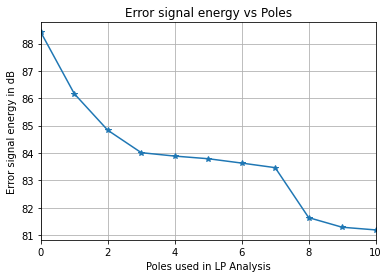

In [15]:
plt.figure()
plt.plot(10*np.log10(Error), marker="*")
plt.title("Error signal energy vs Poles")
plt.xlabel("Poles used in LP Analysis")
plt.ylabel("Error signal energy in dB")
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig("plots/ErrorSignalEnergy.png")

We see that the error signal energy decreases as order increases, implying error decreases as better approximation

4. Show the pole-zero plots of the estimated all-pole filter for p=6,10; comment. 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


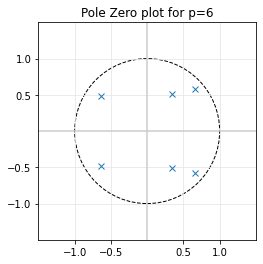

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


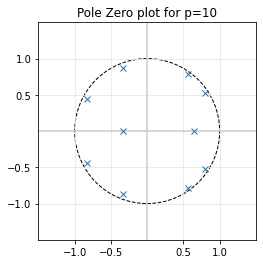

In [16]:
def pole_zero(z, p):
    # get a figure/plot
    ax = plt.subplot(111)

    # create the unit circle
    uc = patches.Circle((0,0), radius=1, fill=False,
                        color='black', ls='dashed')
    ax.add_patch(uc)
    plt.axvline(0, color='0.8')
    plt.axhline(0, color='0.8')
    
    # Plot the poles
    plt.plot(p.real, p.imag, 'x')
    
    # Plot the zeros
    plt.plot(z.real, z.imag,  'o')

    r = 1.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
    ticks = [-1, -.5, .5, 1]; plt.xticks(ticks); plt.yticks(ticks)


order = [6,10]
for i in order:
    coeff_den = [a[i][0],*(-a[i][1:i+1])]
    # print(poles)
    z,p,k = sg.tf2zpk(Gain[i],coeff_den)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title('Pole Zero plot for p='+str(i))
    pole_zero(z, p)
    plt.grid(True, color='0.9')
    plt.savefig("plots/PoleZeroPlot_"+str(i)+".png")
    plt.show()

Comments -
- For p=6, we see 6 poles. 3 conjugate pairs. For p=10, we see 10 poles, two of which lie on real axis and 4 conjugate pairs.
- From the pole zero plot, we can estimate the formant frequencies. Each formant frequency results in a conjugate pair of poles. ($z = re^{j\theta}, r = e^{-\pi BT_s}, \theta = 2\pi FT_s$)
- Thus, for p=6, we can determine 3 formant frequencies and bandwidths (back calculation using the formulas). Here, bandwidth is more as radius is not close to unit circle.
- For p=10, we see that the poles are nearly touching the unit circle, pointing to the fact that the bandwidths of the filter are estimated quite accurately. We also note that as the order increases in LP analysis, the poles and the formants estimated also increase.

5. Compute the gain and plot the LPC spectrum magnitude (i.e. the dB magnitude 
frequency response of the estimated all-pole filter) for each order "p". Comment on the 
characteristics of the spectral envelope estimates. Comment on their shapes with 
reference to the short-time magnitude spectrum computed in part 2. 

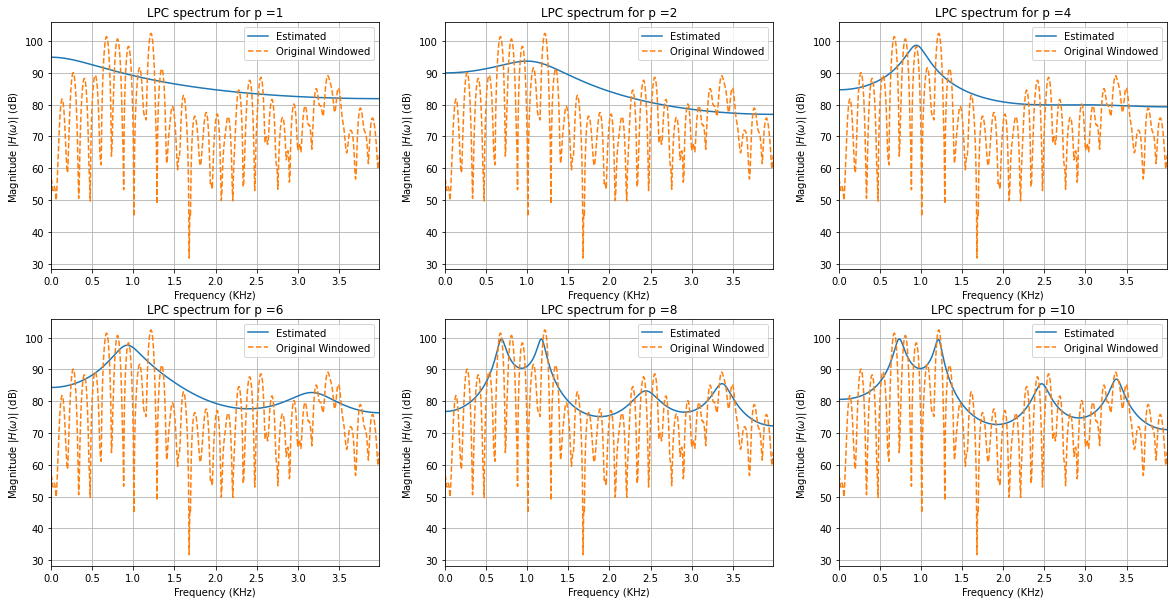

In [19]:
def LPC_spectrum(a,G,Fs,signal,order=[1,2,4,6,8,10]):
    plt.figure(figsize=(20,10))
    w_sig,h_sig = sg.freqz(signal)
    w_khz = (Fs*w_sig/(2*np.pi)/1000)
    h_db = 20*np.log10(abs(h_sig))
    idx = 0
    for i in order:
        poles = [a[i][0],*(-a[i][1:i+1])]
        w,h = sg.freqz(G[i],poles)
        idx+=1
        plt.subplot(2,3,idx)
        plt.plot((Fs*w/(2*np.pi)/1000),20*np.log10(abs(h)),label="Estimated")
        plt.plot(w_khz,h_db,linestyle='dashed',label="Original Windowed")
        plt.title("LPC spectrum for p ="+str(i))
        plt.xlabel("Frequency (KHz)")
        plt.ylabel(r"Magnitude $|H(\omega)|$ (dB)")
        plt.grid()
        plt.xlim(xmin=0)
        plt.legend()
        plt.autoscale(enable=True, axis='x', tight=True)

    plt.savefig("plots/LPCspectrum.png")

LPC_spectrum(a,Gain,Fs,narrowband_output)

In [18]:
order = [2,4,6,8,10]
for i in order:
  print("Gain at p="+str(i), Gain[i])

Gain at p=2 17439.900708647587
Gain at p=4 15641.487995424246
Gain at p=6 15188.203475307033
Gain at p=8 12072.62713580561
Gain at p=10 11464.094072677828


Comments - 
- We can clearly see that as p increases (order of LP coefficients), the estimated magnitude spectrum gets closer to the original magnitude spectrum of windowed segment.
- We also see that it tries to match the peaks as the error is more there due to magnitude. Also, we notice that the estimate is always below the peaks and above the troughs (depressions).
- For p=1, there is no formant estimated. For p=2, one formant estimated very slightly. For p=4, one formant estimated quite prominently. For p=6, two formants estimated. For p=8, four formants estimated. For p=10, four formants estimated and the peaks are more prominent than p=8.
- We also see that as order p increases, Gain decreases. This is evident also from the Energy vs poles plot before. Also from the formula of gain.

6. Based on the 10th-order LP coefficients, carry out the inverse filtering of the /a/ vowel 
segment to obtain the residual error signal. Can you measure the pitch period of the 
voiced sound from the residual waveform? Use the acf to detect the pitch. Compare the 
acf plots of the original speech and residual signals. 


Index of first maxima: 120
Index of second maxima: 61
F0 detected:  135.59322033898306 Hz


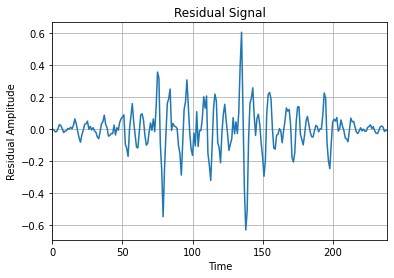

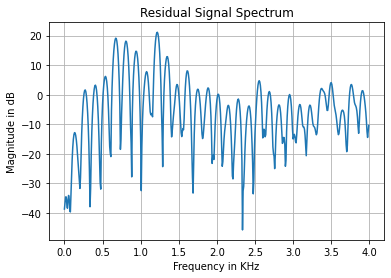

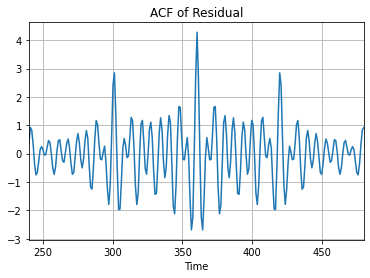

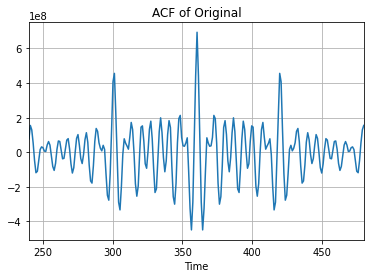

In [27]:
def autocorrelation(gain,coeff,signal):
    duration = 30
    window_duration = int((duration/1000)*Fs)
    signal_length = signal.shape[0] 
    # inverse_filter = np.zeros(signal_length)
    inverse_filter = np.copy(signal)
    # print(inverse_filter)
    for i in range(signal_length):
        # inverse_filter[i] = signal[i]
        for j in range(min(i+1,len(coeff))):
            inverse_filter[i] -= coeff[j]*signal[i-j]
        inverse_filter[i] /= gain
    # print(inverse_filter)
    r_inverse = np.correlate(inverse_filter,inverse_filter,mode="same") #output of same length
    # print(r_inverse)
    r_signal = np.correlate(signal,signal,mode="same") #output of same length

    first = np.argmax(r_inverse)
    print("Index of first maxima:",first)
    second = np.argmax(r_inverse[r_inverse<0.8*np.max(r_inverse)])
    print("Index of second maxima:",second)
    F0 = (Fs/(first - second))
    print("F0 detected: ",F0,"Hz")
    
    return inverse_filter, F0, r_inverse, r_signal

inverse_filter, F0, r_inverse, r_signal = autocorrelation(Gain[10], a[10], narrowband_output)

plt.figure()
plt.plot(inverse_filter)
plt.title("Residual Signal")
plt.xlabel("Time")
plt.ylabel("Residual Amplitude")
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig("plots/ResidualPlot.png")

w,h = sg.freqz(inverse_filter)
plt.figure()
plt.plot((Fs*w/(2*np.pi)/1000),20*np.log10(abs(h)),label="Estimated")
plt.grid()
plt.title("Residual Signal Spectrum")
plt.xlabel("Frequency in KHz")
plt.ylabel("Magnitude in dB")
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig("plots/ResidualPlotSpectrum.png")

plt.figure()
plt.title("ACF of Residual")
plt.plot(xticks,r_inverse) #using xticks from before
plt.xlabel("Time")
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig("plots/ACFResidual.png")

plt.figure()
plt.title("ACF of Original")
plt.plot(xticks,r_signal) #using xticks from before
plt.xlabel("Time")
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig("plots/ACFOriginal.png")


Comments -
- We can estimate the pitch period from the spectrum of residual signal. Here there are 7 peaks in 1kHz, meaning approximate F0 = 1000/7 = 142.86 Hz (which is quite near to ACF estimate)
- The more precise fundamental frequency of the input signal can be calculated from the auto correlation of the residual signal by measuring the distance (time spacing) between the peaks and mapping it to frequency scale. The obtainde Fo = 135.59 Hz
- The first maxima is taken as the one with highest magnitude and the second maxima is taken after applying a threshold of 0.8 so that unnecessary peaks are not calculated. After calculating the time spacing between the two, sampling frequency is used to map it to the frequency scale using formula F0 = Fs/(first_maxima - second_maxima).
- The Auto correlation plot of residual signal has very similar shape as the original auto correlation plot. Just the magnitude is smaller in the residual auto correlation plot.


#### Bonus - reconstruct the sound. 
That is, use the best estimated LP filter with an ideal impulse train of the estimated pitch 
period as source excitation. Carry out de-emphasis on the output waveform. Set the 
duration of the synthesized sound to be 300 ms at 8 kHz sampling frequency and view 
the waveform as well as listen to your created sound. 
Comment on the similarity with the original sound. Try out voice modification using 
this analysis-synthesis method (e.g. change the voice pitch).

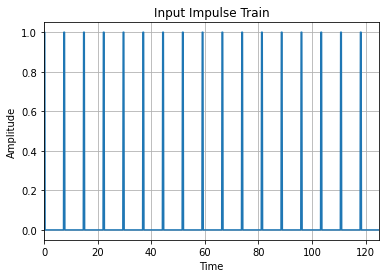

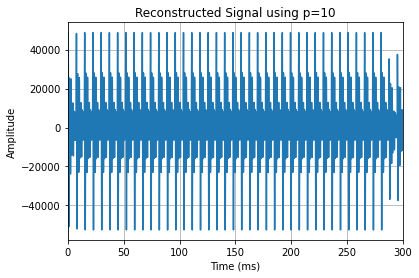

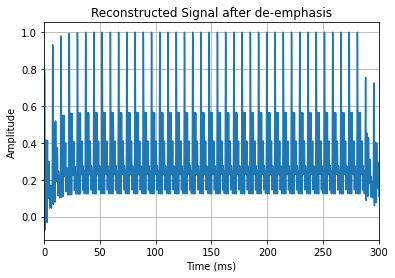

In [29]:
duration = 300
time = int((duration/1000)*Fs)
t = np.linspace(0,duration,time)
source_exc = (sg.square(2*np.pi*F0*t/1000,duty=0.05)+1)/2 # 1 is added to move -1 to 0; divided by 2 to move back to 1. Range [0,1]

plt.figure()
plt.plot(t[:1000], source_exc[:1000])
plt.title("Input Impulse Train")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig("plots/ImpulseSourceExcitation.png")

# Best LP filter is for highest order p=10. Its gain and coeff are used
coeff = a[10]
length = source_exc.shape[0]
output = np.zeros(length)
for i in range(length):
    output[i] = Gain[10]*source_exc[i]
    for j in range(min(i+1,len(coeff))):
        output[i] += coeff[j]*output[i-j] 

plt.figure()
plt.plot(t,output)
plt.title("Reconstructed Signal using p=10")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig("plots/ReconstructedSignal.png")

alpha = 0.98 # same as that of used in pre-emphasis
de_emphasis = np.copy(output) #initialise
for i in range(length):
  de_emphasis[i]+=alpha*de_emphasis[i-1]

de_emphasis = de_emphasis/np.max(de_emphasis) #normalize

plt.figure()
plt.plot(t,de_emphasis)
plt.title("Reconstructed Signal after de-emphasis")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig("plots/ReconstructedSignalDeemphasized.png")

wav.write("Reconstructed_Wave.wav",Fs,output)
wav.write("Reconstructed_Wave_Deemphasized.wav",Fs,de_emphasis)

In [30]:
print('De-emphasized Reconstructed Audio')
Audio(data=output, rate=Fs)

De-emphasized Reconstructed Audio


In [31]:
print('Not De-emphasized Reconstructed Audio')
Audio(data=output, rate=Fs)

Not De-emphasized Reconstructed Audio


In [32]:
print('Original Audio')
Audio(data=signal, rate=Fs)

Original Audio


Comments - 
- For de-emphasis, same alpha=0.98 as used in pre-emphasis.
- The obtained sound is similar to that of original. We can clearly identify the phone /a/. However, it does sound a little mechanized (maybe owing to the fact that it is larger in duration than the original, so ear perception is different)
- However, this method of reconstruction helps in Bit saving and also increases Bit rate. Quite efficient for telecommunications.

In [ ]:
# !zip -r /content/plots.zip /content/plots